# Implementación del modelo

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import itertools    
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import pathlib

In [2]:
data_dir = pathlib.Path('dataset')

In [16]:
image_count = len(list(data_dir.glob('*/*/*.jpg'))) + len(list(data_dir.glob('*/*/*.png')))
print("Total no of images =", image_count)

num_classes = 19
img_channels = 3

Total no of images = 12443


In [20]:
img_height = 64
img_width = 64

# Arquitectura del modelo
model = Sequential([
  layers.Conv2D(19, 3, padding='same', activation='relu', input_shape=(img_height, img_width, img_channels)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 19)        532       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 19)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        5504      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 64)        

In [23]:
# Cargar el train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir / 'train',
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=None
)

# Cargar el test dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir / 'test',
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False,
    seed=42,
    validation_split=None
)

Found 9954 files belonging to 19 classes.
Found 2489 files belonging to 19 classes.


In [24]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/25
312/312 [==============================] - 47s 142ms/step - loss: 5.0548 - accuracy: 0.3113 - val_loss: 1.2263 - val_accuracy: 0.6364
Epoch 2/25
312/312 [==============================] - 50s 160ms/step - loss: 0.8527 - accuracy: 0.7383 - val_loss: 0.6190 - val_accuracy: 0.8140
Epoch 3/25
312/312 [==============================] - 50s 159ms/step - loss: 0.4703 - accuracy: 0.8565 - val_loss: 0.4648 - val_accuracy: 0.8634
Epoch 4/25
312/312 [==============================] - 43s 137ms/step - loss: 0.2866 - accuracy: 0.9073 - val_loss: 0.4836 - val_accuracy: 0.8759
Epoch 5/25
312/312 [==============================] - 43s 137ms/step - loss: 0.1867 - accuracy: 0.9370 - val_loss: 0.3438 - val_accuracy: 0.9120
Epoch 6/25
312/312 [==============================] - 43s 138ms/step - loss: 0.1442 - accuracy: 0.9526 - val_loss: 0.5467 - val_accuracy: 0.8783
Epoch 7/25
312/312 [==============================] - 43s 137ms/step - loss: 0.1620 - accuracy: 0.9469 - val_loss: 0.3961 - val_ac

In [50]:
frame = pd.DataFrame(history.history)

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

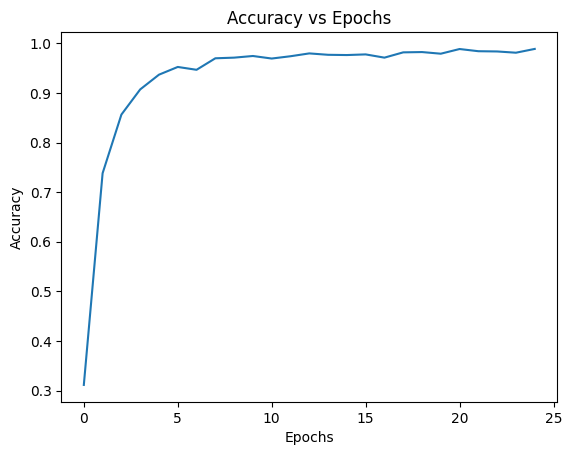

In [51]:
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

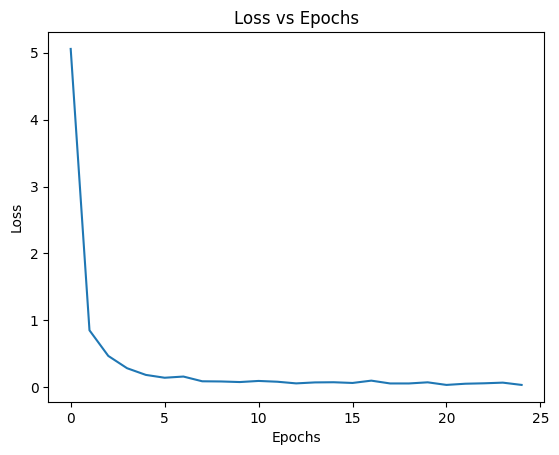

In [52]:
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")

78/78 [==============================] - 5s 64ms/step


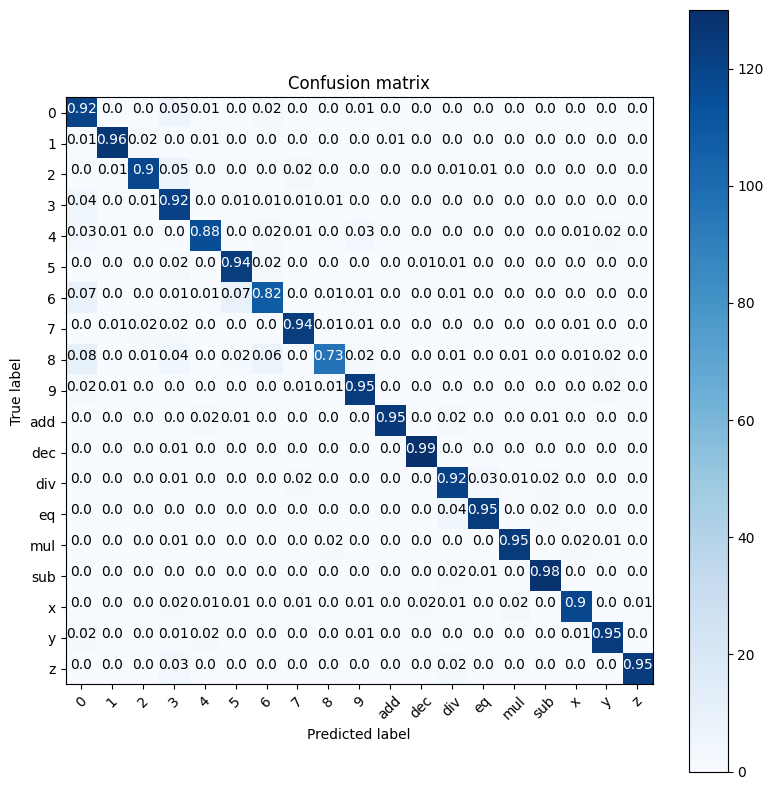

In [41]:
y_pred = model.predict(val_ds)
y_pred = tf.nn.softmax(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)

# Generar matriz de confusion
cm = confusion_matrix(true_categories, predicted_categories)

# Calcular accuracy
accuracy = np.sum(cm.diagonal()) / np.sum(cm)

class_names = train_ds.class_names

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

figure = plot_confusion_matrix(cm, class_names)
plt.show()

In [44]:
print("\nTest Accuracy:", accuracy)

print("\n\nClassification Report:")
print(classification_report(true_categories, predicted_categories, target_names=class_names))


Test Accuracy: 0.9208517476898352


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       131
           1       0.97      0.96      0.97       131
           2       0.95      0.90      0.93       131
           3       0.78      0.92      0.85       131
           4       0.93      0.88      0.91       131
           5       0.90      0.94      0.92       131
           6       0.86      0.82      0.84       131
           7       0.93      0.94      0.94       131
           8       0.94      0.73      0.82       131
           9       0.91      0.95      0.93       131
         add       0.99      0.95      0.97       131
         dec       0.98      0.99      0.98       131
         div       0.88      0.92      0.90       131
          eq       0.95      0.95      0.95       131
         mul       0.96      0.95      0.95       131
         sub       0.96      0.98      0.97       131
           x       0.

Un modelo de CNN con una precisión de 0.92 (92%) para el reconocimiento de símbolos matemáticos escritos a mano puede considerarse bastante efectivo ya que indica que el modelo es capaz de clasificar correctamente el 92% de las imágenes de prueba que se le presentan. Sin embargo, para determinar si el modelo funciona correctamente o no, es importante considerar el contexto bajo el que se evalúa la precisión del modelo y los requisitos específicos del problema, ya que en algunos casos, un 92% de precisión puede ser suficiente, mientras que en otros se pueden requerir niveles más altos de precisión.